In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('weatherHistory.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [4]:
new_df = df.loc[:,['Formatted Date','Temperature (C)']]
df_train =  new_df.loc[:9839,['Formatted Date','Temperature (C)']]
df_val = new_df.loc[9840:12299,['Formatted Date','Temperature (C)']]

In [5]:
dates = df['Formatted Date'].values
temp  = df['Temperature (C)'].values

dates_train = df_train['Formatted Date'].values
temp_train  = df_train['Temperature (C)'].values

dates_val = df_val['Formatted Date'].values
temp_val  = df_val['Temperature (C)'].values

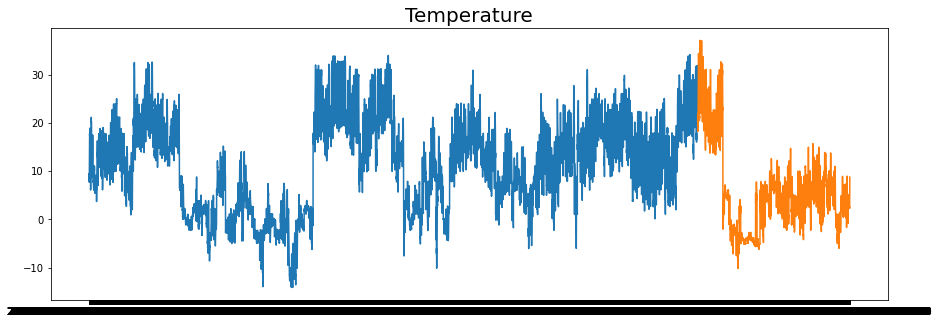

In [6]:
plt.figure(figsize=(15,5))
plt.plot(dates_train,temp_train)
plt.title("Temperature",
          fontsize=20);
plt.plot(dates_val,temp_val)
plt.title("Temperature",
          fontsize=20);          

In [8]:
new_df

,Formatted Date,Temperature (C)
0,2006-04-01 00:00:00.000 +0200,9.472222
1,2006-04-01 01:00:00.000 +0200,9.355556
2,2006-04-01 02:00:00.000 +0200,9.377778
3,2006-04-01 03:00:00.000 +0200,8.288889
4,2006-04-01 04:00:00.000 +0200,8.755556
...,...,...
96448,2016-09-09 19:00:00.000 +0200,26.016667
96449,2016-09-09 20:00:00.000 +0200,24.583333
96450,2016-09-09 21:00:00.000 +0200,22.038889
96451,2016-09-09 22:00:00.000 +0200,21.522222


In [9]:
df_train

,Formatted Date,Temperature (C)
0,2006-04-01 00:00:00.000 +0200,9.472222
1,2006-04-01 01:00:00.000 +0200,9.355556
2,2006-04-01 02:00:00.000 +0200,9.377778
3,2006-04-01 03:00:00.000 +0200,8.288889
4,2006-04-01 04:00:00.000 +0200,8.755556
...,...,...
9835,2007-08-21 19:00:00.000 +0200,28.772222
9836,2007-08-21 20:00:00.000 +0200,25.877778
9837,2007-08-21 21:00:00.000 +0200,23.750000
9838,2007-08-21 22:00:00.000 +0200,22.105556


In [10]:
df_train.isnull().sum()

Formatted Date     0
Temperature (C)    0
dtype: int64

In [11]:
df_val

,Formatted Date,Temperature (C)
9840,2007-08-22 00:00:00.000 +0200,21.483333
9841,2007-08-22 01:00:00.000 +0200,19.933333
9842,2007-08-22 02:00:00.000 +0200,21.833333
9843,2007-08-22 03:00:00.000 +0200,18.866667
9844,2007-08-22 04:00:00.000 +0200,18.266667
...,...,...
12295,2007-01-05 07:00:00.000 +0100,2.466667
12296,2007-01-05 08:00:00.000 +0100,2.316667
12297,2007-01-05 09:00:00.000 +0100,2.966667
12298,2007-01-05 10:00:00.000 +0100,5.927778


In [12]:
df_val.isnull().sum()

Formatted Date     0
Temperature (C)    0
dtype: int64

In [13]:
pip install sklearn

In [14]:
# Normalize
min_max_scaler = MinMaxScaler(feature_range = (0,1))
temp_scale_train = min_max_scaler.fit_transform(df_train[['Temperature (C)']])
df_train[['Temperature (C)']]=temp_scale_train
temp_scale_train

array([[0.48775158],
       [0.4853364 ],
       [0.48579643],
       ...,
       [0.78332375],
       [0.7492812 ],
       [0.75882691]])

In [15]:
#menerima sebuah series/atribut kita yang telah dikonversi menjadi tipe numpy, lalu mengembalikan label dan atribut dari dataset dalam bentuk batch
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [16]:
train_set = windowed_dataset(temp_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(temp_val, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])

In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_mae')<0.09):
      print("MAE model telah mencapai < 10%! ")
      self.model.stop_training = True
callbacks = myCallback()

In [38]:
#pada optimizer, kita akan menggunakan parameter learning rate dan momentum
#Loss function Huber
#metrik evaluasi model MAE
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-01, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50, callbacks=[callbacks], validation_data=test_set)

Epoch 1/50
98/98 [==============================] - 8s 51ms/step - loss: 9.0197e-04 - mae: 0.0308 - val_loss: 4.2231 - val_mae: 4.6829
Epoch 2/50
98/98 [==============================] - 4s 37ms/step - loss: 8.7090e-04 - mae: 0.0307 - val_loss: 4.2196 - val_mae: 4.6792
Epoch 3/50
98/98 [==============================] - 4s 38ms/step - loss: 8.9039e-04 - mae: 0.0310 - val_loss: 4.2257 - val_mae: 4.6854
Epoch 4/50
98/98 [==============================] - 4s 37ms/step - loss: 8.8237e-04 - mae: 0.0306 - val_loss: 4.2212 - val_mae: 4.6807
Epoch 5/50
98/98 [==============================] - 4s 38ms/step - loss: 8.8724e-04 - mae: 0.0306 - val_loss: 4.2188 - val_mae: 4.6782
Epoch 6/50
98/98 [==============================] - 4s 38ms/step - loss: 8.8426e-04 - mae: 0.0305 - val_loss: 4.2311 - val_mae: 4.6910
Epoch 7/50
98/98 [==============================] - 4s 38ms/step - loss: 8.9711e-04 - mae: 0.0310 - val_loss: 4.2288 - val_mae: 4.6885
Epoch 8/50
98/98 [==============================] - 4s 

In [39]:
skala_data = max(temp)-min(temp)
minMae = skala_data * 10/100
minMae

6.172777777777777

In [40]:
model.evaluate(test_set)

24/24 [==============================] - 1s 20ms/step - loss: 4.2444 - mae: 4.7041


[4.244352340698242, 4.704102993011475]

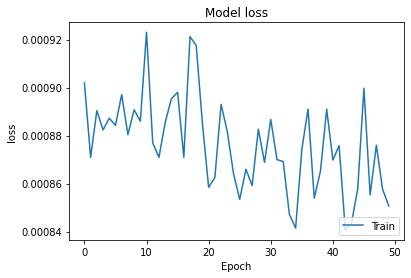

In [41]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

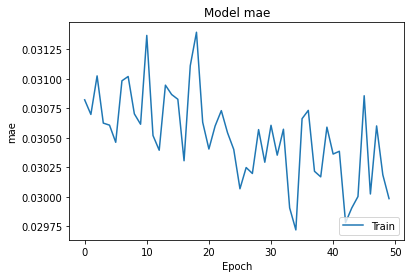

In [42]:
plt.plot(history.history['mae'])
plt.title('Model mae')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()